In [155]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [156]:
df = pd.read_csv('dataset.csv')
df.drop('sID', axis=1, inplace=True)
df

,Datetime,Count
0,25-08-2012 00:00,8
1,25-08-2012 01:00,2
2,25-08-2012 02:00,6
3,25-08-2012 03:00,2
4,25-08-2012 04:00,2
...,...,...
11851,31-12-2013 19:00,286
11852,31-12-2013 20:00,256
11853,31-12-2013 21:00,228
11854,31-12-2013 22:00,216


In [157]:
df.Datetime = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Datetime.values
df.drop('Datetime', axis=1, inplace=True)

In [158]:
df

,Count
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2
...,...
2013-12-31 19:00:00,286
2013-12-31 20:00:00,256
2013-12-31 21:00:00,228
2013-12-31 22:00:00,216


In [159]:
training_index = int(len(df.Count) * 0.9)
training=df[0:training_index] 
test=df[training_index:]

In [160]:
training

,Count
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2
...,...
2013-11-12 09:00:00,128
2013-11-12 10:00:00,186
2013-11-12 11:00:00,162
2013-11-12 12:00:00,260


In [161]:
test

,Count
2013-11-12 14:00:00,200
2013-11-12 15:00:00,6
2013-11-12 16:00:00,2
2013-11-12 17:00:00,4
2013-11-12 18:00:00,4
...,...
2013-12-31 19:00:00,286
2013-12-31 20:00:00,256
2013-12-31 21:00:00,228
2013-12-31 22:00:00,216


# Import metrics

In [162]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt

def calculate_metrics_and_print_results(test, prediction):
    mae = mean_absolute_error(test, prediction)
    print('Mean Absolute Error: %.3f' % mae)

    mape = mean_absolute_percentage_error(test, prediction)
    print('Mean Absolute Percentage Error %.3f' % mape)

    mse = mean_squared_error(test, prediction)
    print('Mean Squared Error %.3f' % mse)

    rmse = sqrt(mean_squared_error(test, prediction))
    print('Root Mean Squared Error:%.3f' % rmse)

# Create Lags from dataset

In [163]:
from numpy import array

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [164]:
start = 0
middle = np.where(df.index == '2013-11-12 14:00:00')[0][0]
end = len(df.values)

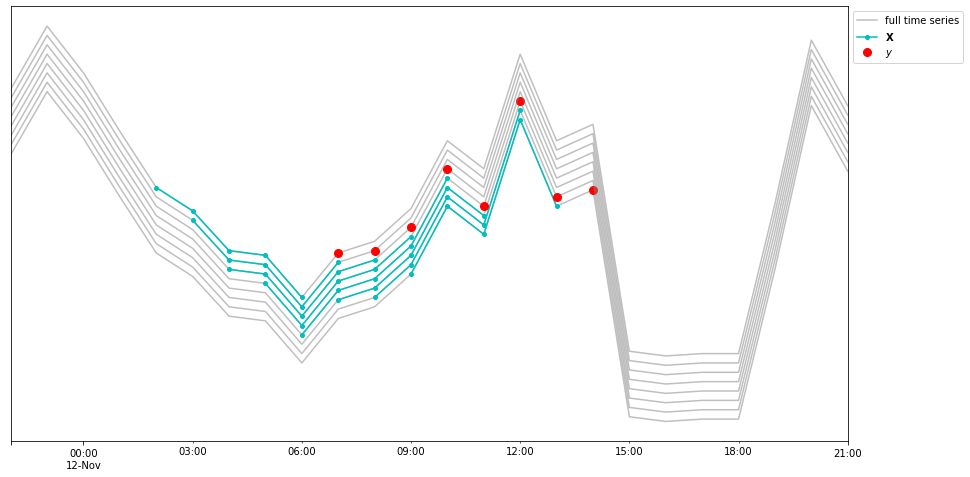

In [165]:
fig, ax = plt.subplots(figsize=(15,8))

window = 5

for i in range(8):

    full = df.Count.iloc[middle - 16:middle+8]
    train = df.Count.iloc[middle - i - window:middle - i ]
    predict = df.Count.iloc[middle - i:middle - i + 1]

    (full + 8*i).plot(ax=ax, c='grey', alpha=0.5)
    (train + 8*i).plot(ax=ax, c='c', markersize=4,
                       marker='o')
    (predict + 8*i).plot(ax=ax, c='r', markersize=8,
                         marker='o', linestyle='')


ax.get_yaxis().set_ticks([])
ax.legend(['full time series',
           '$\mathbf{X}$',
           '$y$'],
          bbox_to_anchor=(1, 1))

# Data Preparation

In [166]:
lag_steps = 24

In [167]:
X, y = split_sequence(training.Count.values, lag_steps)
for i in range(len(X)):
    print(X[i], y[i])

[8 2 6 2 2 2 2 2 6 2 2 6 4 2 6 2 2 2 2 2 2 6 2 2] 4
[2 6 2 2 2 2 2 6 2 2 6 4 2 6 2 2 2 2 2 2 6 2 2 4] 6
[6 2 2 2 2 2 6 2 2 6 4 2 6 2 2 2 2 2 2 6 2 2 4 6] 2
[2 2 2 2 2 6 2 2 6 4 2 6 2 2 2 2 2 2 6 2 2 4 6 2] 4
[2 2 2 2 6 2 2 6 4 2 6 2 2 2 2 2 2 6 2 2 4 6 2 4] 2
[2 2 2 6 2 2 6 4 2 6 2 2 2 2 2 2 6 2 2 4 6 2 4 2] 2
[2 2 6 2 2 6 4 2 6 2 2 2 2 2 2 6 2 2 4 6 2 4 2 2] 2
[2 6 2 2 6 4 2 6 2 2 2 2 2 2 6 2 2 4 6 2 4 2 2 2] 2
[6 2 2 6 4 2 6 2 2 2 2 2 2 6 2 2 4 6 2 4 2 2 2 2] 2
[2 2 6 4 2 6 2 2 2 2 2 2 6 2 2 4 6 2 4 2 2 2 2 2] 4
[2 6 4 2 6 2 2 2 2 2 2 6 2 2 4 6 2 4 2 2 2 2 2 4] 2
[6 4 2 6 2 2 2 2 2 2 6 2 2 4 6 2 4 2 2 2 2 2 4 2] 2
[4 2 6 2 2 2 2 2 2 6 2 2 4 6 2 4 2 2 2 2 2 4 2 2] 8
[2 6 2 2 2 2 2 2 6 2 2 4 6 2 4 2 2 2 2 2 4 2 2 8] 6
[6 2 2 2 2 2 2 6 2 2 4 6 2 4 2 2 2 2 2 4 2 2 8 6] 6
[2 2 2 2 2 2 6 2 2 4 6 2 4 2 2 2 2 2 4 2 2 8 6 6] 6
[2 2 2 2 2 6 2 2 4 6 2 4 2 2 2 2 2 4 2 2 8 6 6 6] 2
[2 2 2 2 6 2 2 4 6 2 4 2 2 2 2 2 4 2 2 8 6 6 6 2] 4
[2 2 2 6 2 2 4 6 2 4 2 2 2 2 2 4 2 2 8 6 6 6 2 4] 4
[2 2 6 2 2 4

In [168]:
from keras.models import Sequential
from keras.layers import Dense

# MLP Model

In [169]:
mlp_model = Sequential()
mlp_model.add(Dense(100, activation='relu', input_dim=lag_steps))
mlp_model.add(Dense(1))
mlp_model.compile(optimizer='adam', loss='mse')

In [170]:
mlp_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 100)               2500      
                                                                 
 dense_19 (Dense)            (None, 1)                 101       
                                                                 
Total params: 2,601
Trainable params: 2,601
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [171]:
mlp_model.fit(X, y, epochs=200, verbose=2, batch_size=32)

Epoch 1/200
333/333 - 0s - loss: 537.6640 - 197ms/epoch - 592us/step
Epoch 2/200
333/333 - 0s - loss: 402.0829 - 102ms/epoch - 306us/step
Epoch 3/200
333/333 - 0s - loss: 396.8910 - 91ms/epoch - 273us/step
Epoch 4/200
333/333 - 0s - loss: 388.1969 - 93ms/epoch - 281us/step
Epoch 5/200
333/333 - 0s - loss: 386.5455 - 93ms/epoch - 280us/step
Epoch 6/200
333/333 - 0s - loss: 376.9661 - 98ms/epoch - 294us/step
Epoch 7/200
333/333 - 0s - loss: 377.2686 - 90ms/epoch - 271us/step
Epoch 8/200
333/333 - 0s - loss: 374.0261 - 93ms/epoch - 280us/step
Epoch 9/200
333/333 - 0s - loss: 373.5708 - 91ms/epoch - 274us/step
Epoch 10/200
333/333 - 0s - loss: 363.6939 - 184ms/epoch - 552us/step
Epoch 11/200
333/333 - 0s - loss: 372.6007 - 130ms/epoch - 390us/step
Epoch 12/200
333/333 - 0s - loss: 357.7039 - 146ms/epoch - 439us/step
Epoch 13/200
333/333 - 0s - loss: 355.9665 - 124ms/epoch - 373us/step
Epoch 14/200
333/333 - 0s - loss: 356.9534 - 101ms/epoch - 304us/step
Epoch 15/200
333/333 - 0s - loss: 35

## Split test data

In [172]:
# x_test = test.Count.values.reshape((1, mlp_lag_steps))
mlp_test, mlp_y = split_sequence(test.Count.values, lag_steps)
mlp_test

array([[200,   6,   2, ..., 236, 296, 214],
       [  6,   2,   4, ..., 296, 214, 252],
       [  2,   4,   4, ..., 214, 252, 250],
       ...,
       [272, 236, 244, ..., 228, 286, 256],
       [236, 244, 250, ..., 286, 256, 228],
       [244, 250, 212, ..., 256, 228, 216]])

In [173]:
# mlp_prediction = mlp_model.predict(mlp_test, verbose=0)
# mlp_prediction = array(mlp_prediction.flatten().tolist())

In [174]:
last_mlp = y[-lag_steps:].reshape((1,-1))
print(last_mlp)
pred_mlp = []
for _ in range(len(test)):
    lstm_prediction = mlp_model.predict(last_mlp, verbose=0)
    # lstm_prediction = array(lstm_prediction.flatten().tolist())
    last_mlp = np.append(last_mlp, lstm_prediction)[1:].reshape((1,-1))
    pred_mlp.append(lstm_prediction)

[[242 282 212 272 316 296 276 266 230 284 244 194 146 126  92  88  52  90
  100 128 186 162 260 186]]


In [177]:
pred_mlp = array(pred_mlp)
pred_mlp = array(pred_mlp.flatten().tolist())
pred_mlp

array([219.0267334 , 222.59272766, 203.036026  , ...,  67.77027893,
        67.9032135 ,  65.85491943])

In [178]:
df_mlp = pd.DataFrame({'Actual': test.Count.values, 'Predicted': pred_mlp})
df_mlp

,Actual,Predicted
0,200,219.026733
1,6,222.592728
2,2,203.036026
3,4,223.875656
4,4,237.740219
...,...,...
1181,286,65.118958
1182,256,67.525894
1183,228,67.770279
1184,216,67.903214


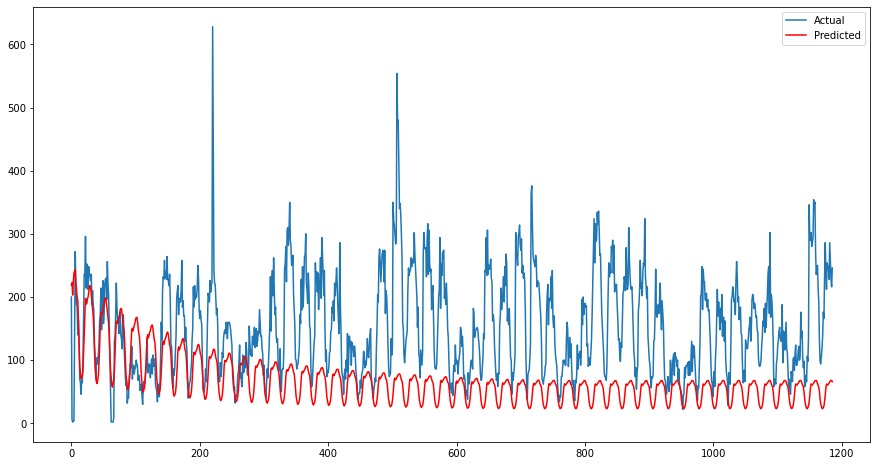

In [179]:
plt.figure(figsize=(15,8))
plt.plot(test.Count.values, label='Actual')
plt.plot(pred_mlp, color='red', label='Predicted')
plt.legend(loc='best')
plt.show()

In [180]:
calculate_metrics_and_print_results(test.Count.values, pred_mlp)

Mean Absolute Error: 90.646
Mean Absolute Percentage Error 0.853
Mean Squared Error 13184.558
Root Mean Squared Error:114.824


# CNN Model

In [ ]:
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lag_steps, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')

In [ ]:
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 23, 64)            192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 704)               0         
                                                                 
 dense_15 (Dense)            (None, 50)                35250     
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 35,493
Trainable params: 35,493
Non-trainable params: 0
__________________________________________________

## Model fit

In [ ]:
cnn_model.fit(X, y, epochs=200, verbose=0)

## Split test data

In [ ]:
cnn_test, cnn_y = split_sequence(test.Count.values, lag_steps)
cnn_test

array([[200,   6,   2, ..., 236, 296, 214],
       [  6,   2,   4, ..., 296, 214, 252],
       [  2,   4,   4, ..., 214, 252, 250],
       ...,
       [272, 236, 244, ..., 228, 286, 256],
       [236, 244, 250, ..., 286, 256, 228],
       [244, 250, 212, ..., 256, 228, 216]])

In [ ]:
cnn_prediction = cnn_model.predict(cnn_test, verbose=0)
cnn_prediction = array(cnn_prediction.flatten().tolist())

In [ ]:
df_cnn = pd.DataFrame({'Actual': cnn_y, 'Predicted': cnn_prediction})
df_cnn

,Actual,Predicted
0,252,249.247055
1,250,302.451111
2,212,335.669312
3,248,238.988022
4,238,226.222656
...,...,...
1157,286,273.252197
1158,256,247.552475
1159,228,268.660706
1160,216,237.585236


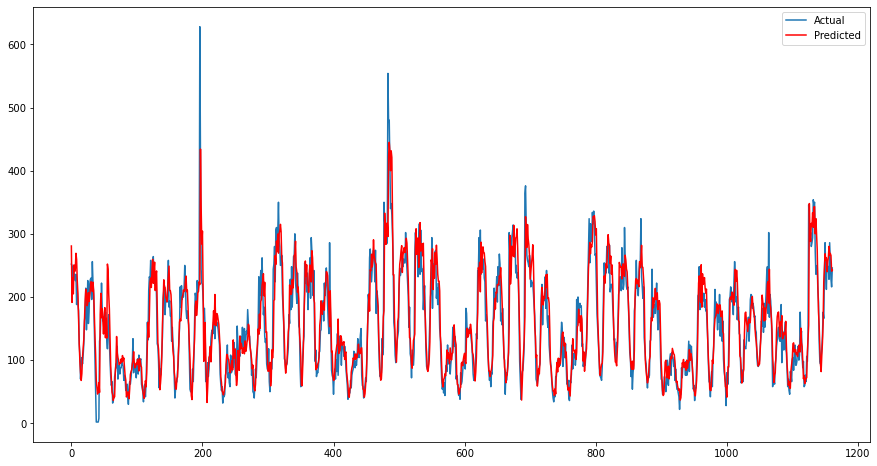

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(mlp_y, label='Actual')
plt.plot(mlp_prediction, color='red', label='Predicted')
plt.legend(loc='best')
plt.show()

In [ ]:
calculate_metrics_and_print_results(cnn_y, cnn_prediction)

Mean Absolute Error: 30.733
Mean Absolute Percentage Error 0.331
Mean Squared Error 1920.804
Root Mean Squared Error:43.827


# LSTM Model

In [ ]:
from keras.layers import LSTM

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(lag_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


## Model fit

In [ ]:
lstm_model.fit(X, y, epochs=200, verbose=0)

# Split test data

In [ ]:
lstm_test, lstm_y = split_sequence(test.Count.values, lag_steps)
lstm_test

array([[200,   6,   2, ..., 236, 296, 214],
       [  6,   2,   4, ..., 296, 214, 252],
       [  2,   4,   4, ..., 214, 252, 250],
       ...,
       [272, 236, 244, ..., 228, 286, 256],
       [236, 244, 250, ..., 286, 256, 228],
       [244, 250, 212, ..., 256, 228, 216]])

In [ ]:
X.shape

(10646, 24)

In [ ]:
y[-lag_steps:].reshape((1,-1)).shape

(1, 24)

In [ ]:
last = y[-lag_steps:].reshape((1,-1))
print(last)
pred = []
for _ in range(len(test)):
    lstm_prediction = lstm_model.predict(last, verbose=0)
    # lstm_prediction = array(lstm_prediction.flatten().tolist())
    last = np.append(last, lstm_prediction)[1:].reshape((1,-1))
    pred.append(lstm_prediction)

[[242 282 212 272 316 296 276 266 230 284 244 194 146 126  92  88  52  90
  100 128 186 162 260 186]]


In [ ]:
pred = array(pred)
pred = array(pred.flatten().tolist())
pred

array([186.3540802 , 194.7063446 , 191.77456665, ...,  22.17352676,
        22.17352676,  22.17352676])

In [ ]:
lstm_y

array([252, 250, 212, ..., 228, 216, 246])

In [ ]:
df_lstm = pd.DataFrame({'Actual': test.Count.values, 'Predicted': pred})
df_lstm

,Actual,Predicted
0,200,186.354080
1,6,194.706345
2,2,191.774567
3,4,190.640945
4,4,186.095566
...,...,...
1181,286,22.173531
1182,256,22.173531
1183,228,22.173527
1184,216,22.173527


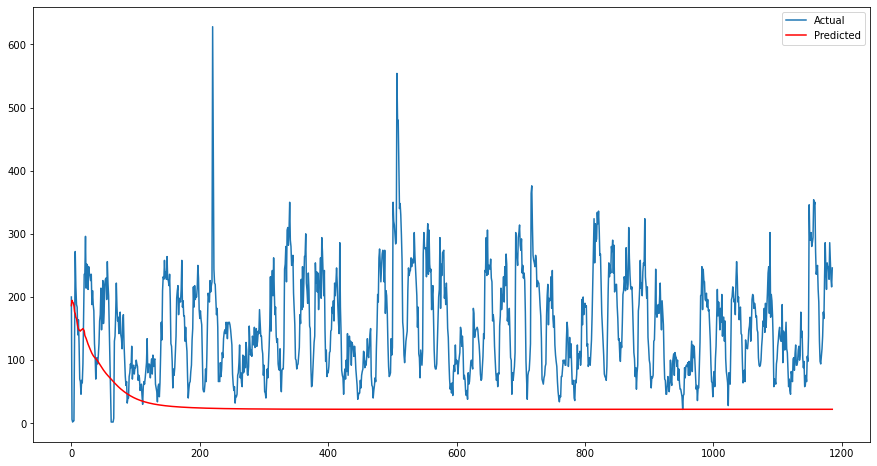

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(test.Count.values, label='Actual')
plt.plot(pred, color='red', label='Predicted')
plt.legend(loc='best')
plt.show()